# Data loading

In [1]:
######## >>>>>>>>>>> For the google colab to be able to access the meta files you must add the APS360 team shared folder to your drive by right clicking on it <<<<<<<<<<< ##############
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
# Prints how many nulls there are in max and min temp
def test_null_csv_daily(station, start_year, end_year, out_name =  None):
    """
      Args:
          station (string): eg. "ON_6158355"
          start_year (int): Starting year
          end_year (int)  : Ending year
          start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
          out_name (optional string) : change the name of the output file
    """
    if out_name == None:
      out_name = station + '_' + str(start_year) + '-' + str(end_year)
    master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
    src_path = master_path + 'datasets/'
    newdf = pd.read_csv(src_path + out_name + ".csv")
    print("Max temp nulls: " + str(newdf['Max Temp (°C)'].isnull().sum()))
    print("Min temp nulls: " + str(newdf['Min Temp (°C)'].isnull().sum()))

In [0]:
import pandas as pd
# Interpolates null values in min and max temp cols
def inter_nulls_csv_daily(station, start_year, end_year, out_name =  None):
    """
      Args:
          station (string): eg. "ON_6158355"
          start_year (int): Starting year
          end_year (int)  : Ending year
          start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
          out_name (optional string) : change the name of the output file
    """
    if out_name == None:
      out_name = station + '_' + str(start_year) + '-' + str(end_year)
    master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
    src_path = master_path + 'datasets/'
    newdf = pd.read_csv(src_path + out_name + ".csv")
    newdf['Max Temp (°C)'] = newdf['Max Temp (°C)'].interpolate()
    newdf['Min Temp (°C)']= newdf['Min Temp (°C)'].interpolate()
    newdf.to_csv( src_path +  out_name + ".csv")

In [0]:
#Raw csv downloaded must be place in /raw folder
#Merged csv will be stored at /datasets folder
# Also interpolates the null max and min temp
def make_csv_daily(station, start_year, end_year, out_name =  None):
  """
    Args:
        station (string): eg. "ON_6158355"
        start_year (int): Starting year
        end_year (int)  : Ending year
        start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
        out_name (optional string) : change the name of the output file
    """
  if out_name == None:
    out_name = station + '_' + str(start_year) + '-' + str(end_year)
  master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
  src_path = master_path + 'raw/'
  dest_path = master_path + 'datasets/'
  fout = open(dest_path + out_name + ".csv","w+")
  in_base = "en_climate_daily_" + station + '_' #eg: 'en_climate_daily_ON_6158355_'
  in_end = '_P1D.csv'
  # first file:
  for line in open(src_path + in_base + str(start_year) + in_end):
      fout.write(line)
  # now the rest:    
  for num in range(start_year + 1, end_year + 1):
      f = open(src_path + in_base + str(num) + in_end)
      f.__next__() # skip the header
      for line in f:
          fout.write(line)
      f.close() # not really needed
  fout.close()
  inter_nulls_csv_daily(station, start_year, end_year, out_name)

In [0]:
####### run once #######
make_csv_daily("ON_6158355", 2007, 2016) # run once
make_csv_daily("ON_6158355", 2017, 2018) # run once
test_null_csv_daily("ON_6158355", 2007, 2016)
test_null_csv_daily("ON_6158355", 2017, 2018)

Max temp nulls: 0
Min temp nulls: 0
Max temp nulls: 0
Min temp nulls: 0


In [0]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
class WeatherDataset(Dataset):
    """Weather dataset."""

    def __init__(self, station, start_year, end_year, start_date = 0, end_date = None, num_days = 7, make_csv = False, out_name = None):
        """
        Args:
            station (string): eg. "ON_6158355"
            start_year (int): Starting year
            end_year (int)  : Ending year
            start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
            end_date (optional int) : end_date = 7 is day 8 of starting year(min = 7 because of LABEL!). If provided changes the end date from last day of last year.
            num_days (optional int) : num_days is the interval of days before the label.
            make_csv (optional bool): If true it will call make_csv_daily function to create the csv from /raw datasets into /datasets
            out_name (optional string) : change the name of the output file which it reads from
        """
        self.num_days = num_days
        if(out_name == None):
          self.out_name = station + '_' + str(start_year) + '-' + str(end_year)
        else:
          self.out_name = out_name
        master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
        dest_path = master_path + 'datasets/'
        if (make_csv):
          make_csv_daily(station, start_year, end_year, out_name =  out_name)

        self.cur_csv = pd.read_csv(dest_path + self.out_name +'.csv')

        self.start_date = start_date
        if( end_date == None):
          self.end_date = len(self.cur_csv) - start_date
        else:
          self.end_date = end_date

    def __len__(self):
        return self.end_date - self.start_date + 1 - self.num_days - 1

    def __getitem__(self, idx):
        data = self.cur_csv.loc[ idx + self.start_date : idx + self.start_date + self.num_days - 1 , ['Max Temp (°C)', 'Min Temp (°C)'] ]
        data = np.asarray(data)
        data = data.astype('float')

        label = self.cur_csv.loc[ idx + self.start_date + self.num_days, ['Max Temp (°C)', 'Min Temp (°C)'] ]
        label = np.asarray(label)
        label = label.astype('float')

        data = data.flatten()

        #print('Data: {}'.format(data))
        #print('Data shape: {}'.format(data.shape))
        #print('Labels shape: {}'.format(label.shape))
        #print('Labels: {}'.format(label[:2]))
        sample = [data, label]

        return sample

In [0]:
start_year_train = 2007
end_year_train = 2016 #changed from 2019 because in our proposal we said 07-16 is train
start_date_train = 0
end_date_train = None
num_days_train = 7
station = "ON_6158355"
trainingSet = WeatherDataset(station, start_year_train, end_year_train, start_date_train, end_date_train, num_days=num_days_train, make_csv = False)

In [0]:
trainingSet[2]

[array([ 8.1,  2.4, 10.1,  4.8, 11.9,  7.7, 10. ,  4.1,  4.8,  3.3,  5.4,
         0.5,  2.5, -3.7]), array([-1.9, -5.7])]

In [0]:
start_year_val = 2017
end_year_val = 2018
start_date_val = 0
end_date_val = None
num_days_val = 7
# station stays the same
validationSet = WeatherDataset(station, start_year_val, end_year_val, start_date_val, end_date_val, num_days_val, make_csv = False)

In [0]:
import torch
train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=2, 
                                            num_workers=1, shuffle=True)
for i, data in enumerate(train_loader, 0):
  input, label = data
  print("input:")
  print(input)
  print("label:")
  print(label)

# ANN TRAINING

In [0]:
import os 
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import datasets, models, transforms 
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms 
use_cuda = True

#we prolly need cuda? to speed things up?

### Helper functions

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "/content/gdrive/My Drive/APS360 Team/milestone 1/Checkpoints/weatherANNmodel_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
# not sure if this is needed

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

In [0]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

### Visualization of data

In [0]:
# laterrrrrrr

### Architecture

In [0]:
# input size: 14 (the highs and hows for the past 7 days)
# output size: 2 (the highs and lows for the next day)
# batch size is 2

# gonna go with a multilayer ann?
# online: cnns good for image and audio, prolly not for text
# either case we know that a recurrant is prolly the best for this


In [0]:
class ann(nn.Module):
  def __init__(self):
    super(ann, self).__init__()
    self.name = "weatherANN"
    self.layer1 = nn.Linear(14, 50) #input tensor size 14
    self.layer2 = nn.Linear(50, 2) #output tensor size 2
  def forward(self, x):
    activation1 = self.layer1(x)
    activation1 = F.relu(activation1)
    activation2 = self.layer2(activation1) 
    return activation2

In [0]:
class ann2(nn.Module):
  def __init__(self):
    super(ann2, self).__init__()
    self.name = "ann2"
    self.layer1 = nn.Linear(14, 50) #input tensor size 14
    self.layer2 = nn.Linear(50, 20) #output tensor size 2
    self.layer3 = nn.Linear(20, 2) #output tensor size 2
  def forward(self, x):
    activation1 = self.layer1(x)
    activation1 = F.relu(activation1)
    activation2 = self.layer2(activation1)
    activation2 = F.relu(activation2)
    activation3 = self.layer3(activation2) 
    return activation3

### Training

In [0]:
# Error defined as mean difference of prediction and reallity
def compute_error(outputs, labels):
  err = 0.0
  number_items = 0
  for j, out in enumerate(outputs, 0):
      err += abs(labels[j][0] - out[0])
      err += abs(labels[j][1] - out[1])
      number_items += 2

  return err, number_items

In [0]:
# Error defined as prediction being off more than 5°C
def compute_error(outputs, labels):
  err = 0.0
  number_items = 0
  for j, out in enumerate(outputs, 0):
      err += (abs(labels[j][0] - out[0]) > 3)
      err += (abs(labels[j][1] - out[1]) > 3)
      number_items += 2

  return err, number_items

In [0]:
def get_accuracy(net, loader, criterion):

    total_loss = 0.0
    total_err = 0.0
    number_items = 0

    for i, data in enumerate(loader, 0):
      inputs, labels = data
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
      #############################################
      outputs = net(inputs.float())
      loss = criterion(outputs, labels.float()) 
      total_loss += loss.item()
      
      cur_err, cur_num = compute_error(outputs, labels)
      total_err += cur_err
      number_items += cur_num
    err = float(total_err) / number_items
    loss = float(total_loss) / (i + 1)
    return err, loss

In [0]:
# what are we using as the validation loader
# regression midek: should use MSE (?)
def train(net, trainingSet, validationSet, batch_size, num_epochs, learning_rate):
    torch.manual_seed(777)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validationSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        number_items = 0
        for i, data in enumerate(train_loader, 0): # Itterate through each batch
            #print("Training", i, "out of", len(train_loader))
            # Get the inputs
            inputs, labels = data

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            outputs = net(inputs.float())             # forward pass
            loss = criterion(outputs, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()

            cur_err, cur_num = compute_error(outputs, labels)
            total_train_err += cur_err
            number_items += cur_num
             

        train_err[epoch] = float(total_train_err) / number_items
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = get_accuracy(net, val_loader, criterion)
        
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
                "Validation err: {}, Validation loss: {}").format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        #print(model_path) #for debugging the path smh
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    


In [34]:
weather_ann = ann2() # note ann2
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.000501, num_epochs=45)

Training Started...
Epoch 1: Train err: 7.178987169772629, Train loss: 90.98394433787611 |Validation err: 3.2992449899782446, Validation loss: 18.020292320251464
Epoch 2: Train err: 3.1812195803433343, Train loss: 16.55994692005095 |Validation err: 2.9559151171442544, Validation loss: 14.9919136428833
Epoch 3: Train err: 2.840219972652114, Train loss: 13.385518804925386 |Validation err: 2.6630673604923327, Validation loss: 12.023521766662597
Epoch 4: Train err: 2.658606378128896, Train loss: 11.890625996667831 |Validation err: 2.5682953323133257, Validation loss: 11.121750373840332
Epoch 5: Train err: 2.5748306420238505, Train loss: 11.249422190619297 |Validation err: 2.584092643730249, Validation loss: 11.27472972869873
Epoch 6: Train err: 2.5295777334535527, Train loss: 10.911878171514292 |Validation err: 2.510009078715475, Validation loss: 10.889336585998535
Epoch 7: Train err: 2.503712515407772, Train loss: 10.699006854510698 |Validation err: 2.5182047901930154, Validation loss: 10

In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.002, num_epochs=45)

Training Started...
Epoch 1: Train err: 3.60737575603489, Train loss: 22.787634239822136 |Validation err: 2.7385967201968064, Validation loss: 12.566592044830323
Epoch 2: Train err: 2.6580406860960815, Train loss: 11.826540595195333 |Validation err: 2.6404233831649497, Validation loss: 12.021636447906495
Epoch 3: Train err: 2.5544062402962915, Train loss: 11.056058012071203 |Validation err: 2.7760418461687233, Validation loss: 12.31431643486023
Epoch 4: Train err: 2.5140255390673065, Train loss: 10.698915094625754 |Validation err: 2.470620819602167, Validation loss: 10.22242015838623
Epoch 5: Train err: 2.485068100608982, Train loss: 10.463067203271585 |Validation err: 2.4685949101652516, Validation loss: 10.309986991882324
Epoch 6: Train err: 2.4744519748411835, Train loss: 10.378384402540863 |Validation err: 2.5890140189478794, Validation loss: 11.317685852050781
Epoch 7: Train err: 2.462982881736555, Train loss: 10.300771443570246 |Validation err: 2.524217216908561, Validation loss:

In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.001, num_epochs=45)

Training Started...
Epoch 1: Train err: 4.900919666132857, Train loss: 47.26424972346572 |Validation err: 2.998146898161195, Validation loss: 14.904623222351074
Epoch 2: Train err: 2.8308051607976004, Train loss: 13.210910038869889 |Validation err: 2.6185783432716736, Validation loss: 12.21290464401245
Epoch 3: Train err: 2.6299763289660656, Train loss: 11.637036339181368 |Validation err: 2.5757088725291513, Validation loss: 11.22637487411499
Epoch 4: Train err: 2.5802393022778047, Train loss: 11.248068872045298 |Validation err: 2.550008465821647, Validation loss: 10.952122821807862
Epoch 5: Train err: 2.539516394055918, Train loss: 10.900080157107995 |Validation err: 2.5575893905822746, Validation loss: 11.076239566802979
Epoch 6: Train err: 2.5131053290338214, Train loss: 10.743656392957343 |Validation err: 2.5109960828635995, Validation loss: 10.987037181854248
Epoch 7: Train err: 2.502979680417985, Train loss: 10.630572772416912 |Validation err: 2.4993806182013962, Validation loss:

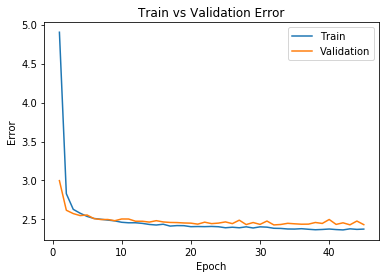

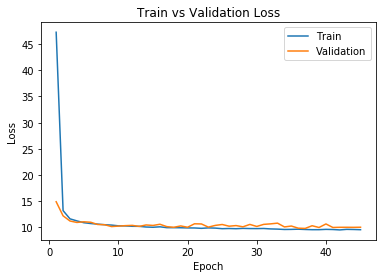

In [0]:
model_path = get_model_name("weatherANN", batch_size=30, learning_rate=0.001, epoch=45)

plot_training_curve(model_path)

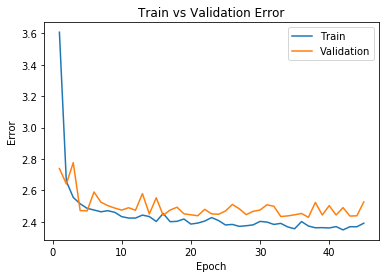

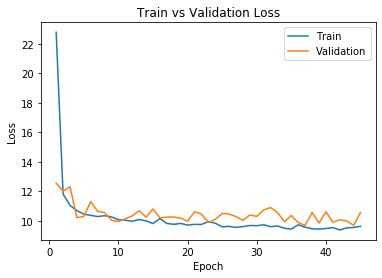

In [0]:
model_path = get_model_name("weatherANN", batch_size=30, learning_rate=0.002, epoch=45)

plot_training_curve(model_path)

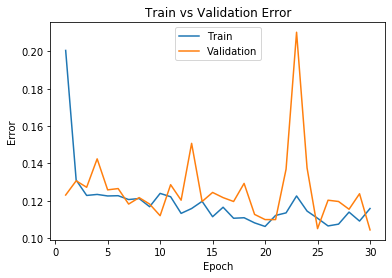

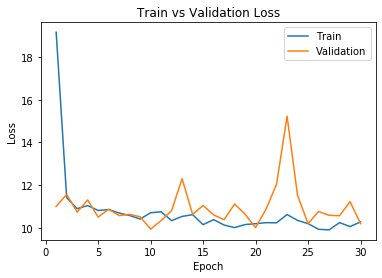

In [0]:
model_path = get_model_name("weatherANN", batch_size=30, learning_rate=0.01, epoch=30)

plot_training_curve(model_path)


### Tuning

In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.001, num_epochs=25)

Training Started...
Epoch 1: Train err: 4.682002304577672, Train loss: 40.61352743867968 |Validation err: 3.081118802985012, Validation loss: 15.934245071411134
Epoch 2: Train err: 2.914657087295701, Train loss: 13.966742695355025 |Validation err: 2.6983442940817497, Validation loss: 12.738037471771241
Epoch 3: Train err: 2.6695499330887618, Train loss: 11.95144690841925 |Validation err: 2.6234686188245218, Validation loss: 11.567892589569091
Epoch 4: Train err: 2.5911308136136424, Train loss: 11.33603841359498 |Validation err: 2.543768744325564, Validation loss: 10.891461715698242
Epoch 5: Train err: 2.5316573064127934, Train loss: 10.881336489661795 |Validation err: 2.5340434899455118, Validation loss: 10.947654495239258
Epoch 6: Train err: 2.4989382516147303, Train loss: 10.66131217753301 |Validation err: 2.4950465075016015, Validation loss: 10.90026050567627
Epoch 7: Train err: 2.482390166560687, Train loss: 10.503282781507147 |Validation err: 2.505240298085234, Validation loss: 10

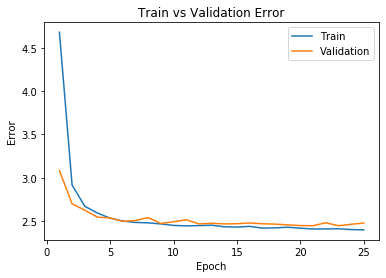

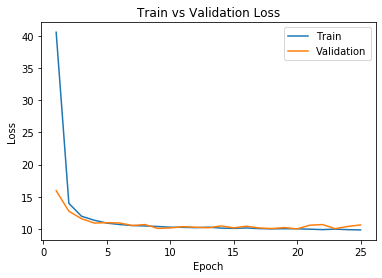

In [0]:
model_path = get_model_name("weatherANN", batch_size=30, learning_rate=0.001, epoch=25)

plot_training_curve(model_path)


In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.001, num_epochs=20)

Training Started...
Epoch 1: Train err: 4.262496596804031, Train loss: 26.67093849182129 |Validation err: 4.035029686199358, Validation loss: 26.507369995117188
Epoch 2: Train err: 4.1795805488068325, Train loss: 25.811220169067383 |Validation err: 4.019066175875755, Validation loss: 26.24588394165039
Epoch 3: Train err: 4.097890851245477, Train loss: 24.979337692260742 |Validation err: 4.003472494749496, Validation loss: 26.007240295410156
Epoch 4: Train err: 4.017736039711878, Train loss: 24.175546646118164 |Validation err: 3.988184953968113, Validation loss: 25.789913177490234
Epoch 5: Train err: 3.937363332796555, Train loss: 23.398359298706055 |Validation err: 3.9731157330366282, Validation loss: 25.593896865844727
Epoch 6: Train err: 3.857186154046884, Train loss: 22.64872932434082 |Validation err: 3.9583280201141653, Validation loss: 25.418418884277344
Epoch 7: Train err: 3.7772157214581976, Train loss: 21.92758560180664 |Validation err: 3.9439883398321958, Validation loss: 25.2

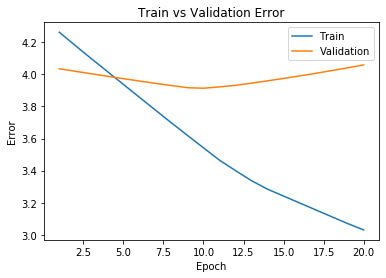

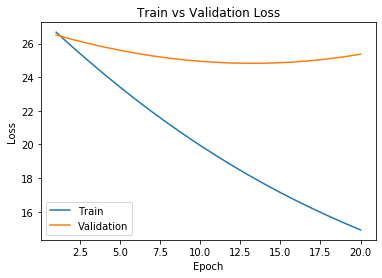

In [0]:
model_path = get_model_name("weatherANN", batch_size=30, learning_rate=0.001, epoch=20)

plot_training_curve(model_path)

In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=5, learning_rate=0.001, num_epochs=20)

Training Started...
Epoch 1: Train err: 5.040452079990735, Train loss: 37.07516543070475 |Validation err: 4.664611750841141, Validation loss: 33.88273557027181
Epoch 2: Train err: 4.832870336106191, Train loss: 36.02789052327474 |Validation err: 4.5938614742113995, Validation loss: 31.59462547302246
Epoch 3: Train err: 4.63837989133138, Train loss: 33.46707089742025 |Validation err: 4.529921471270232, Validation loss: 31.798144658406574
Epoch 4: Train err: 4.474254599930001, Train loss: 27.85562260945638 |Validation err: 4.464512770336408, Validation loss: 28.12669499715169
Epoch 5: Train err: 4.281400995988113, Train loss: 29.295787811279297 |Validation err: 4.406614486901805, Validation loss: 26.96812375386556
Epoch 6: Train err: 4.129009302075093, Train loss: 25.398649215698242 |Validation err: 4.348238628271681, Validation loss: 27.618584314982098
Epoch 7: Train err: 3.978298982834587, Train loss: 25.238545735677082 |Validation err: 4.309709430134927, Validation loss: 28.0197893778

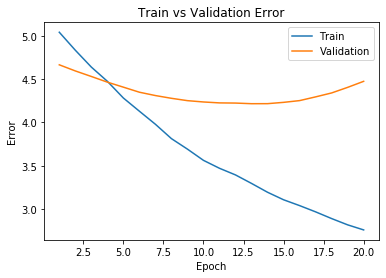

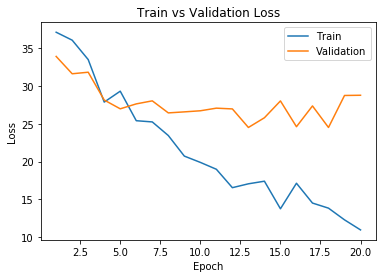

In [0]:
model_path = get_model_name("weatherANN", batch_size=5, learning_rate=0.001, epoch=20)

plot_training_curve(model_path)

In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=1, learning_rate=0.0001, num_epochs=40)

Training Started...
Epoch 1: Train err: 4.434667583383045, Train loss: 27.963903463803806 |Validation err: 4.7209519360501035, Validation loss: 33.11322788091806
Epoch 2: Train err: 4.389112207150229, Train loss: 27.356935794536884 |Validation err: 4.6955520726167235, Validation loss: 32.789386345789985
Epoch 3: Train err: 4.3409023506710165, Train loss: 26.793628729306736 |Validation err: 4.674284549057484, Validation loss: 32.51304248663095
Epoch 4: Train err: 4.292904229519459, Train loss: 26.280598933880146 |Validation err: 4.65239438076432, Validation loss: 32.25115702702449
Epoch 5: Train err: 4.244359678918352, Train loss: 25.724754883692814 |Validation err: 4.632407217071606, Validation loss: 31.98953155370859
Epoch 6: Train err: 4.200763927170864, Train loss: 25.25868657919077 |Validation err: 4.620491814727968, Validation loss: 31.747530937194824
Epoch 7: Train err: 4.154218953504013, Train loss: 24.763115956233097 |Validation err: 4.60509791970253, Validation loss: 31.503867

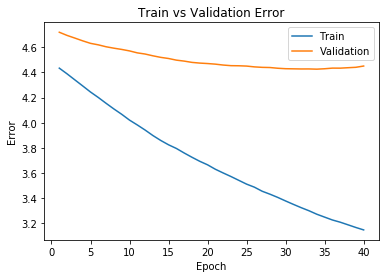

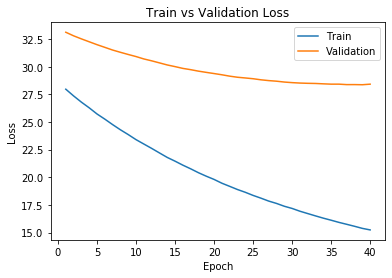

In [0]:
model_path = get_model_name("weatherANN", batch_size=1, learning_rate=0.0001, epoch=40)

plot_training_curve(model_path)

In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet, batch_size=100, learning_rate=0.001, num_epochs=10)

Training Started...
Epoch 1: Train err: 4.262496596804031, Train loss: 26.67093849182129 |Validation err: 4.035029686199358, Validation loss: 26.507369995117188
Epoch 2: Train err: 4.1795805488068325, Train loss: 25.811220169067383 |Validation err: 4.019066175875755, Validation loss: 26.24588394165039
Epoch 3: Train err: 4.097890851245477, Train loss: 24.979337692260742 |Validation err: 4.003472494749496, Validation loss: 26.007240295410156
Epoch 4: Train err: 4.017736039711878, Train loss: 24.175546646118164 |Validation err: 3.988184953968113, Validation loss: 25.789913177490234
Epoch 5: Train err: 3.937363332796555, Train loss: 23.398359298706055 |Validation err: 3.9731157330366282, Validation loss: 25.593896865844727
Epoch 6: Train err: 3.857186154046884, Train loss: 22.64872932434082 |Validation err: 3.9583280201141653, Validation loss: 25.418418884277344
Epoch 7: Train err: 3.7772157214581976, Train loss: 21.92758560180664 |Validation err: 3.9439883398321958, Validation loss: 25.2

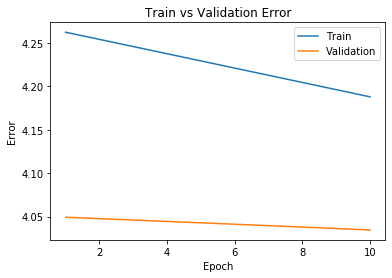

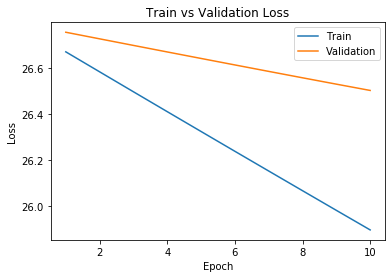

In [0]:
model_path = get_model_name("weatherANN", batch_size=100, learning_rate=0.0001, epoch=10)

plot_training_curve(model_path)

best model???



In [0]:
# lowest validation error thus far has been 3.9 lol
# batch:100
# lr = 0.001
# epoch 10

# Graveyard of codes

c######################################################################
c######################################################################
a##########OOOOOOO#####################################OOOOOOO##########
a##########OOOOOOO#####################################OOOOOOO##########
a##########OOOOOOO#####################################OOOOOOO##########
a##########OOOOOOO#####################################OOOOOOO##########
c#######################################################################
c###############################^^^^^^^^^^^^^^##############################
c################################^^^^^^^^^^^###############################
c#################################^^^^^^^^^##############################













In [0]:
import pandas as pd
import numpy as np

start_date = 0
num_days = 7
station = "ON_6158355"
out_name = station + '_' + str(start_year) + '-' + str(end_year)
master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
dest_path = master_path + 'datasets/'
landmarks_frame = pd.read_csv(dest_path + out_name +'.csv')

n = 65
img_name = landmarks_frame.iloc[ start_date : start_date + num_days, [9, 11] ]
img_name = np.asarray(img_name)
landmarks = landmarks_frame.iloc[ start_date + num_days + 1, [9, 11] ]
landmarks = np.asarray(landmarks)
#landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:2]))

Image name: [[10.1  2.6]
 [ 6.4  0.7]
 [ 8.1  2.4]
 [10.1  4.8]
 [11.9  7.7]
 [10.   4.1]
 [ 4.8  3.3]]
Landmarks shape: (2,)
First 4 Landmarks: [2.5 -3.7]


In [0]:
len(landmarks_frame)

4748

In [0]:
import pandas as pd
import numpy as np
start_year = 2007
end_year = 2019
start_date = 0
num_days = 7
station = "ON_6158355"
out_name = station + '_' + str(start_year) + '-' + str(end_year)
master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
dest_path = master_path + 'datasets/'
cur_csv = pd.read_csv(dest_path + out_name +'.csv')

n = 65
data = cur_csv.loc[ :6 , ['Max Temp (°C)', 'Min Temp (°C)'] ]
data = np.asarray(data)
data = data.astype('float')
label = cur_csv.loc[ 6, ['Max Temp (°C)', 'Min Temp (°C)'] ]
label = np.asarray(label)
label = label.astype('float')

data = data.flatten()
#data = np.expand_dims(data, axis=0)
#data = data.reshape((2,7))
label = np.asarray(label)
data = np.asarray(data)

print('Image name: {}'.format(data))
print('Image shape: {}'.format(data.shape))
print('Landmarks shape: {}'.format(label.shape))
print('First 4 Landmarks: {}'.format(label[:2]))

sample = [data, label]
sample

Image name: [10.1  2.6  6.4  0.7  8.1  2.4 10.1  4.8 11.9  7.7 10.   4.1  4.8  3.3]
Image shape: (14,)
Landmarks shape: (2,)
First 4 Landmarks: [4.8 3.3]


[array([10.1,  2.6,  6.4,  0.7,  8.1,  2.4, 10.1,  4.8, 11.9,  7.7, 10. ,
         4.1,  4.8,  3.3]), array([4.8, 3.3])]